In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings 
warnings.filterwarnings('ignore') 

In [3]:
file_path = "/Volumes/abdullah/Programlama/PYTHON/Miul/git_folder/Data_set/House Prices - Advanced Regression Techniques/"

train_df = pd.read_csv(file_path +'train.csv')
test_df = pd.read_csv(file_path +'test.csv')

print(f"Eğitim verisi başlangıç boyutu: {train_df.shape}")
print(f"Test verisi başlangıç boyutu: {test_df.shape}")

train_ids = train_df['Id']
test_ids = test_df['Id']
train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

y_train_raw = train_df['SalePrice']
y_train_log = np.log1p(y_train_raw)
train_df.drop('SalePrice', axis=1, inplace=True)
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)

print(f"Test ve eğitim veri seti birleştirilmiştir, boyutu (SalePrice hariç): {all_data.shape}")


Eğitim verisi başlangıç boyutu: (1460, 81)
Test verisi başlangıç boyutu: (1459, 80)
Test ve eğitim veri seti birleştirilmiştir, boyutu (SalePrice hariç): (2919, 79)


In [ ]:
missing_data_percent = all_data.isnull().sum() / len(all_data) * 100
missing_data_percent = missing_data_percent[missing_data_percent > 0].sort_values(ascending=False)

print("Birleştirilmiş veri setindeki eksik değerlerin oranları (ilk 15):")
print(missing_data_percent.head(15).round(2))


Tüm birleştirilmiş verideki eksik değer oranları (ilk 15):
PoolQC          99.66
MiscFeature     96.40
Alley           93.22
Fence           80.44
MasVnrType      60.50
FireplaceQu     48.65
LotFrontage     16.65
GarageFinish     5.45
GarageQual       5.45
GarageCond       5.45
GarageYrBlt      5.45
GarageType       5.38
BsmtExposure     2.81
BsmtCond         2.81
BsmtQual         2.77
dtype: float64


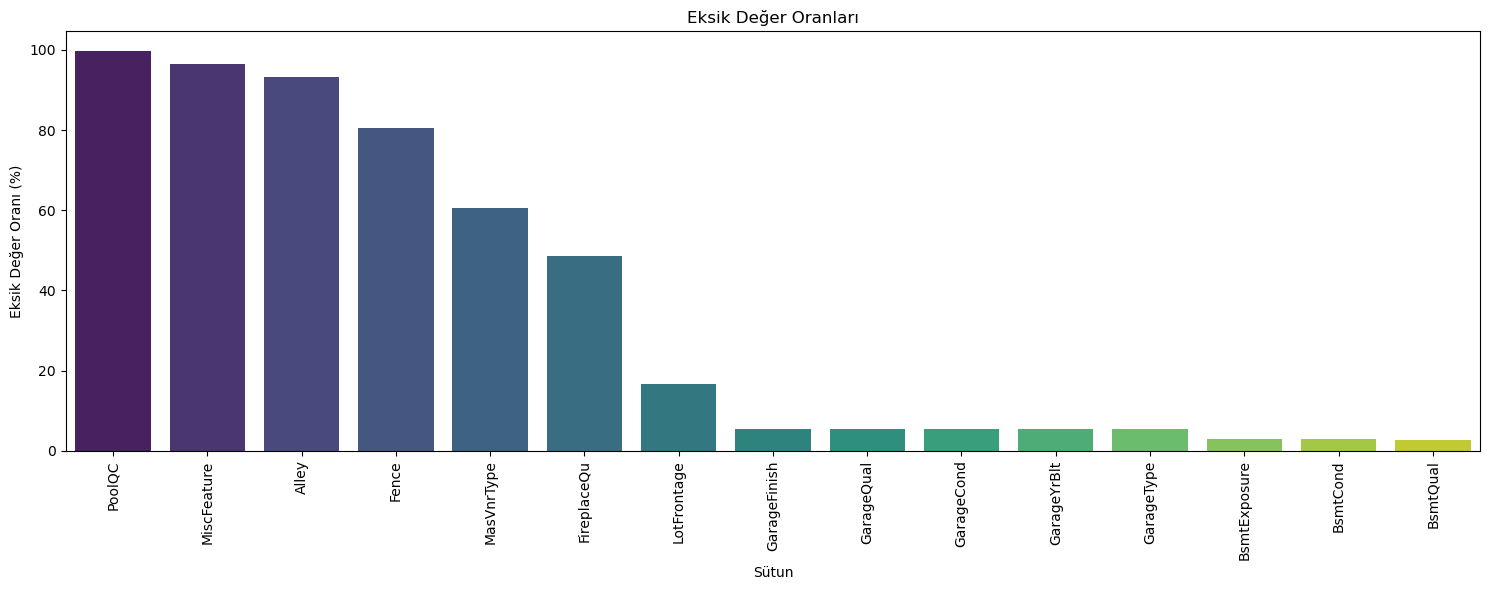

In [5]:
plt.figure(figsize=(15, 6))
sns.barplot(x=missing_data_percent.index[:15], y=missing_data_percent.values[:15], palette='viridis')
plt.xticks(rotation=90)
plt.title('Eksik Değer Oranları')
plt.ylabel('Eksik Değer Oranı (%)')
plt.xlabel('Sütun')
plt.tight_layout()
plt.show()


In [6]:
##Eksik değerleri dolduralım 
cols_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond',
             'MasVnrType'] 

for col in cols_none:
    all_data[col] = all_data[col].fillna('None')

cols_zero_numeric = ['GarageYrBlt', 'GarageArea', 'GarageCars',
                     'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
                     'MasVnrArea'] 

for col in cols_zero_numeric:
    all_data[col] = all_data[col].fillna(0)

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

cols_mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional']
for col in cols_mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
quality_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}

for col in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
            'GarageQual', 'GarageCond', 'PoolQC']:
    all_data[col] = all_data[col].map(quality_mapping).fillna(0)

print(f"\nÖn işleme sonrası toplam eksik değer sayısı: {all_data.isnull().sum().sum()}")


Ön işleme sonrası toplam eksik değer sayısı: 2


In [7]:
# sayısal görünümlü katagorik değerler
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str) 
all_data['OverallQual'] = all_data['OverallQual'].astype(str) 
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] #toplam alan
all_data['TotalBath'] = (all_data['FullBath'] + (all_data['HalfBath'] * 0.5) +
                         all_data['BsmtFullBath'] + (all_data['BsmtHalfBath'] * 0.5)) #toplam banyo sayısı
all_data['YearsSinceBuilt'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['YearsSinceRemodel'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['YearsSinceRemodel'] = all_data['YearsSinceRemodel'].apply(lambda x: x if x >= 0 else 0)
all_data['GarageAge'] = all_data['YrSold'] - all_data['GarageYrBlt']
all_data['GarageAge'] = all_data['GarageAge'].apply(lambda x: x if x >= 0 else 0) 
all_data['TotalRooms'] = all_data['TotRmsAbvGrd'] + all_data['BsmtFullBath'] + all_data['BsmtHalfBath'] 


all_data['AvgRoomSF'] = all_data['GrLivArea'] / (all_data['TotRmsAbvGrd'] + all_data['FullBath'] + all_data['HalfBath'] + 1e-6)
all_data['AvgRoomSF'].replace([np.inf, -np.inf], 0, inplace=True) 
all_data['OverallScore'] = all_data['OverallQual'].astype(int) + all_data['OverallCond'].astype(int)
all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + \
                           all_data['3SsnPorch'] + all_data['ScreenPorch']


all_data['OverallQual_GrLivArea'] = all_data['OverallQual'].astype(int) * all_data['GrLivArea']
all_data['KitchenQual_GrLivArea'] = all_data['KitchenQual'].astype(int) * all_data['GrLivArea']


all_data['IsNew'] = (all_data['YearBuilt'] == all_data['YrSold']).astype(int)
all_data.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold'], axis=1, inplace=True)

print("\nÖzellik Mühendisliği sonrası birleştirilmiş veri boyutu:", all_data.shape)


Özellik Mühendisliği sonrası birleştirilmiş veri boyutu: (2919, 87)


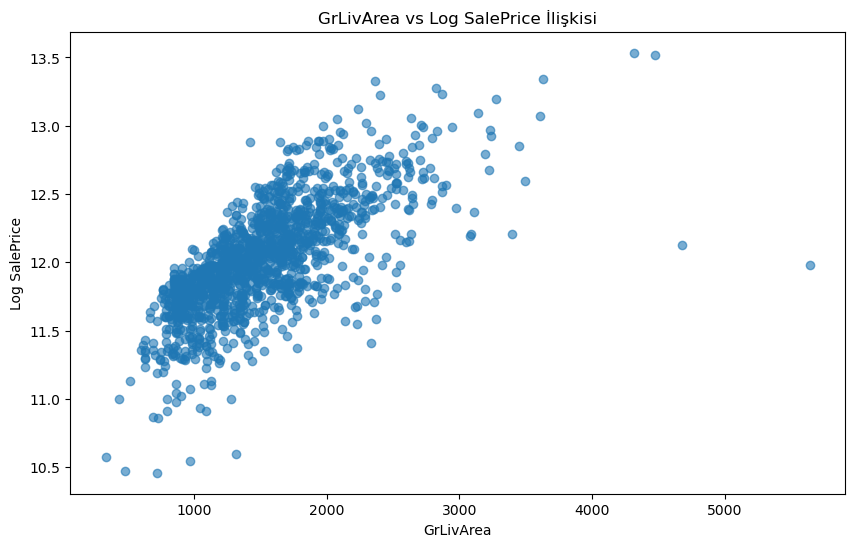

In [8]:
plt.figure(figsize=(10, 6))
plt.scatter(x=all_data['GrLivArea'][:len(y_train_log)], y=y_train_log, alpha=0.6) # Sadece eğitim verisi kadarını görselleştir
plt.xlabel('GrLivArea')
plt.ylabel('Log SalePrice')
plt.title('GrLivArea vs Log SalePrice İlişkisi')
plt.show()


In [9]:
outlier_indices = all_data[(all_data['GrLivArea'] > 4000) & (y_train_log < 12.5)].index

if not outlier_indices.empty:
    all_data = all_data.drop(outlier_indices).reset_index(drop=True)
    y_train_log = y_train_log.drop(outlier_indices).reset_index(drop=True) 

print("\nGrLivArea aykırı değer temizliği sonrası birleştirilmiş veri boyutu:", all_data.shape)


GrLivArea aykırı değer temizliği sonrası birleştirilmiş veri boyutu: (2917, 87)


In [ ]:
# Ordinal kategorik sütunları dönüştür.
quality_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}

for col in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
            'GarageQual', 'GarageCond', 'PoolQC']:
    all_data[col] = all_data[col].map(quality_mapping).fillna(0) 

bsmt_exposure_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
all_data['BsmtExposure'] = all_data['BsmtExposure'].map(bsmt_exposure_mapping).fillna(0)

bsmt_fin_type_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].map(bsmt_fin_type_mapping).fillna(0)
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].map(bsmt_fin_type_mapping).fillna(0)

garage_finish_mapping = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
all_data['GarageFinish'] = all_data['GarageFinish'].map(garage_finish_mapping).fillna(0)
all_data['BsmtQual'] = all_data['BsmtQual'].map(quality_mapping).fillna(0)
all_data['BsmtCond'] = all_data['BsmtCond'].map(quality_mapping).fillna(0)
categorical_cols = all_data.select_dtypes(include='object').columns.tolist()
print("\nOne-Hot Encoding yapılacak kategorik sütunlar (ordinal dönüşüm sonrası):", categorical_cols)


all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)

print("\nOne-Hot Encoding sonrası birleştirilmiş veri boyutu:", all_data.shape)

all_data.columns = all_data.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True) # özel karakterlerden kurtulma


One-Hot Encoding yapılacak kategorik sütunlar (ordinal dönüşüm sonrası): ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

One-Hot Encoding sonrası birleştirilmiş veri boyutu: (2917, 250)


In [11]:
#eğitimsetini ayır
X_train = all_data.iloc[:len(y_train_log), :]
X_test = all_data.iloc[len(y_train_log):, :]
numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)

print(f"\nÖlçeklendirme sonrası Eğitim seti boyutu: {X_train_scaled_df.shape}")
print(f"Ölçeklendirme sonrası Test seti boyutu: {X_test_scaled_df.shape}")


Ölçeklendirme sonrası Eğitim seti boyutu: (1458, 55)
Ölçeklendirme sonrası Test seti boyutu: (1459, 55)


In [12]:
X_final_train = all_data.iloc[:len(y_train_log), :]
X_final_test = all_data.iloc[len(y_train_log):, :] 


X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(
    X_final_train, y_train_log, test_size=0.2, random_state=42
)

scaler_model = StandardScaler()
X_train_model_scaled = scaler_model.fit_transform(X_train_model)
X_test_model_scaled = scaler_model.transform(X_test_model) 

print(f"\nEğitim için  Boyutu: {X_train_model_scaled.shape}")
print(f"Değerlendirme için Boyutu: {X_test_model_scaled.shape}")




Eğitim için  Boyutu: (1166, 250)
Değerlendirme için Boyutu: (292, 250)


In [13]:

### Lineer Regresyon Modeli 
lr_model = LinearRegression()
lr_model.fit(X_train_model_scaled, y_train_model)

y_pred_lr = lr_model.predict(X_test_model_scaled)


mae_lr = mean_absolute_error(y_test_model, y_pred_lr)
mse_lr = mean_squared_error(y_test_model, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test_model, y_pred_lr)

print(f"MAE (Lineer Regresyon): {mae_lr:.4f}")
print(f"RMSE (Lineer Regresyon): {rmse_lr:.4f}")
print(f"R-squared (Lineer Regresyon): {r2_lr:.4f}")


kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr_cv_scores = cross_val_score(lr_model, X_train_model_scaled, y_train_model, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
lr_rmse_cv = np.sqrt(-lr_cv_scores) 

print(f"Lineer Regresyon (5-Fold Cross-Validation) RMSE Ortalaması: {lr_rmse_cv.mean():.4f}")
print(f"Lineer Regresyon (5-Fold Cross-Validation) RMSE Standart Sapması: {lr_rmse_cv.std():.4f}")

MAE (Lineer Regresyon): 1034076654.6843
RMSE (Lineer Regresyon): 10965745884.1777
R-squared (Lineer Regresyon): -713312657534733254656.0000
Lineer Regresyon (5-Fold Cross-Validation) RMSE Ortalaması: 1526520983906.6697
Lineer Regresyon (5-Fold Cross-Validation) RMSE Standart Sapması: 727730657151.6582


In [14]:
## Ridge 

param_grid_ridge = {'alpha': [0.1, 1.0, 10.0, 100.0, 500.0]}
grid_search_ridge = GridSearchCV(Ridge(random_state=42), param_grid_ridge, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ridge.fit(X_train_model_scaled, y_train_model)

best_ridge_model = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_test_model_scaled)

mae_ridge = mean_absolute_error(y_test_model, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test_model, y_pred_ridge))
r2_ridge = r2_score(y_test_model, y_pred_ridge)

print(f"En iyi Ridge parametreleri: {grid_search_ridge.best_params_}")
print(f"MAE (Ridge Regresyon): {mae_ridge:.4f}")
print(f"RMSE (Ridge Regresyon): {rmse_ridge:.4f}")
print(f"R-squared (Ridge Regresyon): {r2_ridge:.4f}")

#Cross-Validation RMSE gridsearch
print(f"Ridge Regresyon (5-Fold Cross-Validation) RMSE Ortalaması: {np.sqrt(-grid_search_ridge.best_score_):.4f}")

En iyi Ridge parametreleri: {'alpha': 500.0}
MAE (Ridge Regresyon): 0.0870
RMSE (Ridge Regresyon): 0.1329
R-squared (Ridge Regresyon): 0.8953
Ridge Regresyon (5-Fold Cross-Validation) RMSE Ortalaması: 0.1145


In [15]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300], # Ağaç sayısı
    'max_features': [0.7, 0.8], 
    'max_depth': [10, 20, None], 
    'min_samples_leaf': [1, 2]
}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train_model_scaled, y_train_model)

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_model_scaled)

mae_rf = mean_absolute_error(y_test_model, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_model, y_pred_rf))
r2_rf = r2_score(y_test_model, y_pred_rf)

print(f"En iyi Random Forest parametreleri: {grid_search_rf.best_params_}")
print(f"MAE (Random Forest): {mae_rf:.4f}")
print(f"RMSE (Random Forest): {rmse_rf:.4f}")
print(f"R-squared (Random Forest): {r2_rf:.4f}")
print(f"Random Forest (5-Fold Cross-Validation) RMSE Ortalaması: {np.sqrt(-grid_search_rf.best_score_):.4f}")

En iyi Random Forest parametreleri: {'max_depth': 20, 'max_features': 0.7, 'min_samples_leaf': 1, 'n_estimators': 200}
MAE (Random Forest): 0.0935
RMSE (Random Forest): 0.1419
R-squared (Random Forest): 0.8806
Random Forest (5-Fold Cross-Validation) RMSE Ortalaması: 0.1297


In [16]:
#  performans özeti
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Random Forest'],
    'MAE': [mae_lr, mae_ridge, mae_rf],
    'RMSE': [rmse_lr, rmse_ridge, rmse_rf],
    'R2': [r2_lr, r2_ridge, r2_rf]
})
print("\n### Model Performans Karşılaştırması ###")
print(results.sort_values(by='RMSE', ascending=True))

best_model = best_rf_model 
y_pred_best = best_model.predict(X_test_model_scaled)



### Model Performans Karşılaştırması ###
               Model           MAE          RMSE            R2
1   Ridge Regression  8.704782e-02  1.328801e-01  8.952573e-01
2      Random Forest  9.353186e-02  1.418840e-01  8.805818e-01
0  Linear Regression  1.034077e+09  1.096575e+10 -7.133127e+20


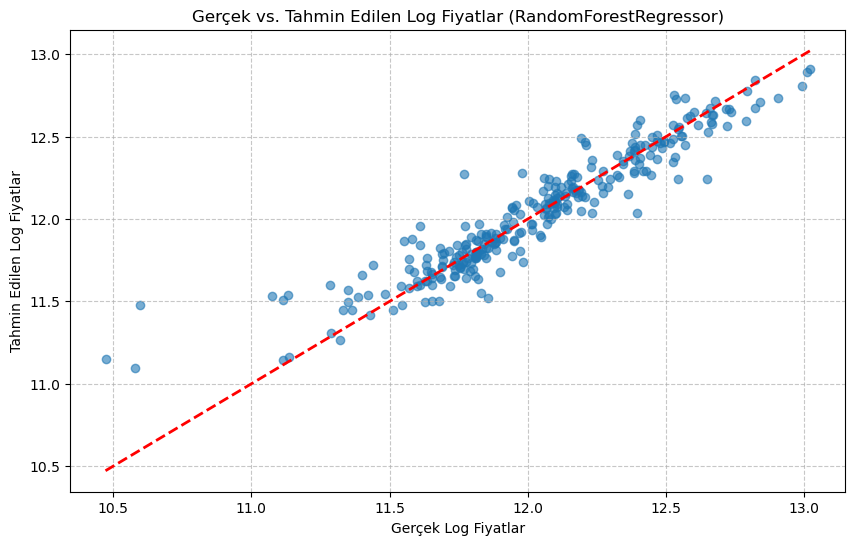

In [17]:

plt.figure(figsize=(10, 6))
plt.scatter(y_test_model, y_pred_best, alpha=0.6)
plt.plot([y_test_model.min(), y_test_model.max()], [y_test_model.min(), y_test_model.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Gerçek Log Fiyatlar')
plt.ylabel('Tahmin Edilen Log Fiyatlar')
plt.title(f'Gerçek vs. Tahmin Edilen Log Fiyatlar ({best_model.__class__.__name__})')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [18]:

y_test_actual = np.expm1(y_test_model)
y_pred_best_actual = np.expm1(y_pred_best)
residuals_actual = y_test_actual - y_pred_best_actual


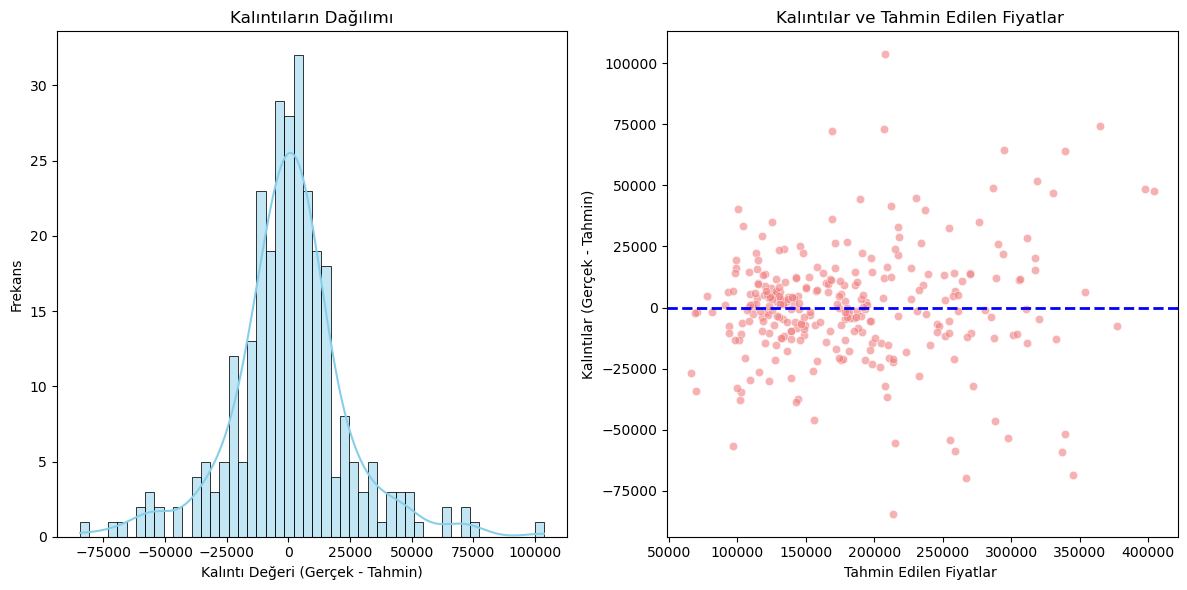

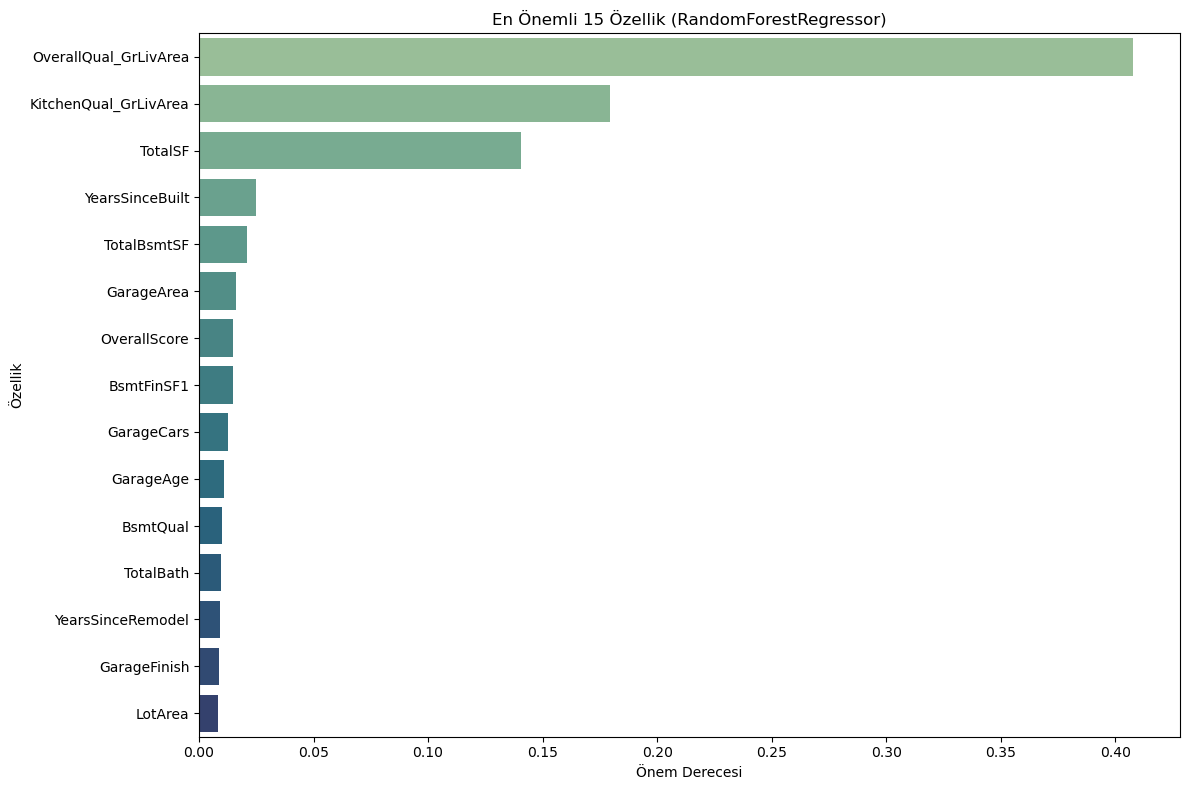

In [19]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals_actual, kde=True, bins=50, color='skyblue')
plt.title('Kalıntıların Dağılımı')
plt.xlabel('Kalıntı Değeri (Gerçek - Tahmin)')
plt.ylabel('Frekans')
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_best_actual, y=residuals_actual, alpha=0.6, color='lightcoral')
plt.axhline(y=0, color='blue', linestyle='--', linewidth=2)
plt.xlabel('Tahmin Edilen Fiyatlar ')
plt.ylabel('Kalıntılar (Gerçek - Tahmin)')
plt.title('Kalıntılar ve Tahmin Edilen Fiyatlar ')
plt.tight_layout()
plt.show()

if hasattr(best_rf_model, 'feature_importances_'):
    feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train_model.columns).sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=feature_importances.head(15).values, y=feature_importances.head(15).index, palette='crest')
    plt.title(f'En Önemli 15 Özellik ({best_rf_model.__class__.__name__})')
    plt.xlabel('Önem Derecesi')
    plt.ylabel('Özellik')
    plt.tight_layout()
    plt.show()



In [20]:
# En büyük hata yapılan tahminler
error_analysis_df = pd.DataFrame({'Actual': y_test_actual, 'Predicted': y_pred_best_actual, 'Residual': residuals_actual})
error_analysis_df['AbsResidual'] = np.abs(error_analysis_df['Residual'])
print("\nEn büyük hata yapılan tahminler (Gerçek Fiyat Ölçeğinde, ilk 10):")
print(error_analysis_df.sort_values(by='AbsResidual', ascending=False).head(10))


En büyük hata yapılan tahminler (Gerçek Fiyat Ölçeğinde, ilk 10):
        Actual      Predicted       Residual    AbsResidual
218   311500.0  207855.017577  103644.982423  103644.982423
665   129000.0  213400.203721  -84400.203721   84400.203721
58    438780.0  364572.627092   74207.372908   74207.372908
451   280000.0  206886.129948   73113.870052   73113.870052
271   241500.0  169203.060403   72296.939597   72296.939597
1030  197000.0  266778.584502  -69778.584502   69778.584502
261   276000.0  344723.091804  -68723.091804   68723.091804
607   359100.0  294776.184435   64323.815565   64323.815565
231   403000.0  338826.520668   64173.479332   64173.479332
1043  278000.0  337174.518777  -59174.518777   59174.518777
